# Gender and age recognition from files

## Data
The data we work with is called "common voice data", first we will look at the CSV file containing information about
the voice files + some basic attributes, upvotes downvotes (we will not need this) gender and age.

## Importing the data

In [1]:
# import the required packages
import pandas as pd
df = pd.read_csv("cv-valid-train.csv")
pd.set_option('display.max_columns', 500)

## Preprocessing data
As we can see there are a number of empty columns, we won't be able to detect the gender without the source information
therefore where the gender column is missing the data will be dropped.

In [2]:
#Identify where gender and age are missing
print(f'This is the length of the dataframe {len(df)}')
null_num = len(df.loc[(pd.isnull(df.gender) & pd.isnull(df.age))])
not_null = len(df.loc[~(pd.isnull(df.gender) & pd.isnull(df.age))])
print(f'This is the length of of rows where both columns are null {not_null}')
print(f'This is the sum of the two should be the length of the df {not_null+null_num}')
# this is just to make sure we negated the the df.gender and df.age not null correctly
valid_df = df.loc[~(pd.isnull(df.gender) & pd.isnull(df.age))]
valid_df.reset_index(inplace=True)
valid_df

This is the length of the dataframe 195776
This is the length of of rows where both columns are null 74361
This is the sum of the two should be the length of the df 195776


,index,filename,text,up_votes,down_votes,age,gender,accent,duration
0,5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
1,8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,3,0,seventies,male,us,NaN
2,13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
3,14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
4,19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN
...,...,...,...,...,...,...,...,...,...
74356,195766,cv-valid-train/sample-195766.mp3,but before i go i want to tell you a little story,1,0,fourties,male,england,NaN
74357,195767,cv-valid-train/sample-195767.mp3,down below in the darkness were hundreds of pe...,3,0,thirties,female,us,NaN
74358,195770,cv-valid-train/sample-195770.mp3,he heard a muffled grating sound and saw the b...,4,0,twenties,male,england,NaN
74359,195771,cv-valid-train/sample-195771.mp3,the englishman said nothing,1,0,thirties,male,england,NaN


<AxesSubplot:>

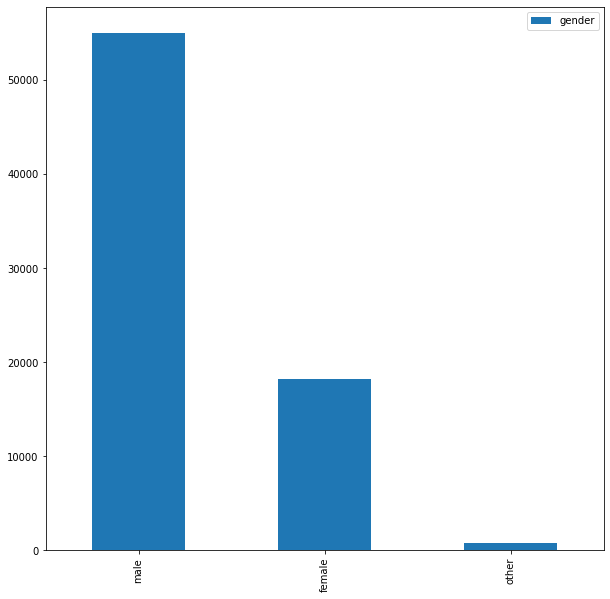

In [3]:
pd.DataFrame(valid_df.gender.value_counts()).plot.bar(figsize=(10,10))

<AxesSubplot:>

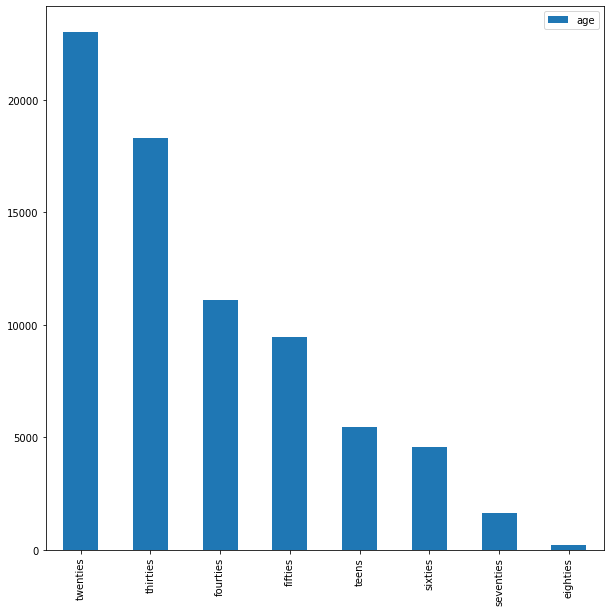

In [4]:
pd.DataFrame(valid_df.age.value_counts()).plot.bar(figsize=(10,10))

Now in a variable we stored valid_df which doesn't contain any missing data, now it is time to collect information on
the voice dataset

# The voice dataset & Feature extraction
Saved in mp3 format we will use a package called librosa to look at the data.
There are a number of complex features that we can extract from the data

* **Spectral centroid** - this takes samples of the recordings using Fourier Transform
the transformation decomposes the waveform of a musical chord into terms of the intensity of its constituent pitches.
The easy way to understand this variable is to imagine a weighted average on the audio file depending on the intensity of high
vs low pitches. This will play a key role in detecting whether this is a male or female.
* **Spectral Bandwidth** is the difference between the upper and lower frequencies in a continuous band of frequencies.
As we know the signals oscillate about a point so if the point is the centroid of the signal then the sum of
maximum deviation of the signal on both sides of the point can be considered as the bandwidth of the signal
at that time frame
* **Spectral roll-off** It can be defined as the action of a specific type of
filter which is designed to roll off the frequencies outside to a specific range. The reason we call
it roll-off is because it is a gradual procedure.
There can be two kinds of filters: hi-pass and low pass and both can roll off the frequency from a signal
going outside of their range.
* **Tonnetz** ?
* **MFCC**
## TO DO
?? let's see if there is more to add to this and also to clarify these


In [5]:
# Writing a function its sole purpose will be to read in an audio file and extract the features mentioned above
import librosa
import os
import errno
import numpy as np

In [6]:
def import_mp3file(path:str, file_name:str, spectral_centroid:bool=True, spectral_bandwidth:bool=True,
                   spectral_roll_off:bool=True, MFCC:bool=True) -> dict:
    """
    :param path: path to the file
    :param file_name: name of the file
    :param spectral_centroid: if true spectral centroid is in the output
    :param spectral_bandwidth: if true spectral bandwidth is in the output
    :param spectral_roll_off: if true roll_off is in the output
    :param MFCC: if true MFCC values are in the output
    :return: filename + dictionary with feature set
    """
    if os.path.isfile(os.path.join(path, file_name)):
        audio, _ = librosa.load(os.path.join(path, file_name))
        output = dict()
        output['filename'] = file_name
        if spectral_centroid:
            spectral_centroid_value = np.mean(librosa.feature.spectral_centroid(y=audio))
            output["spectral_centroid"] = spectral_centroid_value
        if spectral_bandwidth:
            spectral_bandwidth_value = np.mean(librosa.feature.spectral_bandwidth(y=audio))
            output["spectral_bandwidth"] = spectral_bandwidth_value
        if spectral_roll_off:
            spectral_roll_off_value = np.mean(librosa.feature.spectral_rolloff(y=audio))
            output["spectral_rolloff"] = spectral_roll_off_value
        if MFCC:
            MFCC_values = librosa.feature.mfcc(y=audio)
            for i, element in enumerate(MFCC_values):
                output[f'MFCC_{i}'] = np.mean(element)
        return output

    else:
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), os.path.join(path,file_name))


{'filename': 'cv-valid-train/sample-000008.mp3', 'spectral_centroid': 2352.7475565141926, 'spectral_bandwidth': 1854.9463106224644, 'spectral_rolloff': 3968.712890625, 'MFCC_0': -415.57288, 'MFCC_1': 99.58028, 'MFCC_2': -27.460777, 'MFCC_3': 10.333393, 'MFCC_4': 7.2848096, 'MFCC_5': 0.9885974, 'MFCC_6': -22.434021, 'MFCC_7': -21.395174, 'MFCC_8': -16.391228, 'MFCC_9': -7.847973, 'MFCC_10': 0.43195435, 'MFCC_11': 5.885935, 'MFCC_12': -7.2544622, 'MFCC_13': -3.529506, 'MFCC_14': -13.423277, 'MFCC_15': -1.1738807, 'MFCC_16': -7.1814423, 'MFCC_17': 5.562098, 'MFCC_18': -6.6943316, 'MFCC_19': -1.178298}


array([[4460.22175571, 4175.59117068, 3884.60612779, 3374.71829314,
        1144.64655545, 1092.94004371, 1225.65807209, 1266.59594119,
        1232.85026572, 2744.17641222, 4105.00095856, 3749.85456925,
        2332.4429962 , 1651.9227578 , 1553.81723776, 1566.04631018,
        1544.57575462, 1525.91524213, 1576.66014615, 1929.20321356,
        2672.19538181, 2476.3592423 , 1755.23655177, 1611.70976292,
        1461.32540332, 1352.79000052, 1454.62261381, 1340.39012086,
         992.77723306, 1032.26490225, 1148.66817526, 1296.14941814,
        1427.50061457, 1517.80837736, 1472.37735089, 1393.89724893,
        1313.14088119, 1256.17061522, 1163.08342939, 1063.48420999,
         999.93926298, 1031.49493118, 1117.12346428, 1254.74466627,
        1398.78795777, 1528.87036282, 1578.40015717, 1771.66304659,
        3543.62932697, 4743.56534655, 5102.61070267, 5170.89100393,
        5356.37322273, 5557.71014968, 5510.2354996 , 2655.50800088,
        1599.98330424, 1449.93721998, 1466.37987

<Figure size 1600x1120 with 0 Axes>

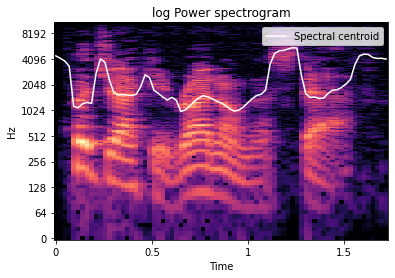

<Figure size 1440x1440 with 0 Axes>

In [44]:
# This is just here to play around with the central spectroid data, see the frequency bins and the averages over time
import matplotlib.pyplot as plt
import librosa.display
#Testing the function - for the errors there is no test for now
path = "./cv-valid-train/"
file_name = valid_df.filename.iloc[1]
test_dict = import_mp3file(path, file_name)
print(test_dict)

audio, _ = librosa.load(os.path.join(path, file_name))
x = librosa.feature.spectral_centroid(y=audio, win_length=2048*1, n_fft=2048*1)
S, phase = librosa.magphase(librosa.stft(y=audio))
plt.figure(figsize=(20, 14), dpi=80)
times = librosa.times_like(x)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, x.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')
plt.figure(figsize=(20,20))
librosa.feature.spectral_centroid(S=S)



## Finally let's build a dataset with the extracted features



In [9]:
# Unfortunately it takes sime to extract these values therefore instead of running it for the whole dataset let's export
# a few records - and to make sure it is a balanced dataset
# if the file has already been extracted
if not os.path.isfile("./cleaned_training_data.csv"):
    print(valid_df.loc[valid_df.gender=="female"].groupby("age").count())
    # There is very few data from eighties and a lot more from younger ppl, let's try to grab 200 records from each category
    unique_ages = list(valid_df.age.unique())
    unique_ages.remove(np.nan)
    print(f'unique ages: {unique_ages}')

    sampled_df = pd.DataFrame()
    for age_group in unique_ages:
       temp_df = pd.DataFrame()
       temp_df = valid_df.loc[(valid_df.gender=="female") & (valid_df.age==age_group)].copy()
       sampled_df = sampled_df.append(temp_df[:400])

    for age_group in unique_ages:
       temp_df = pd.DataFrame()
       temp_df = valid_df.loc[(valid_df.gender=="male") & (valid_df.age==age_group)].copy()
       sampled_df = sampled_df.append(temp_df[:400])

    sampled_df.to_csv("cleaned_training_data.csv", index=False)

else:
    sampled_df = pd.read_csv("./cleaned_training_data.csv")

<AxesSubplot:>

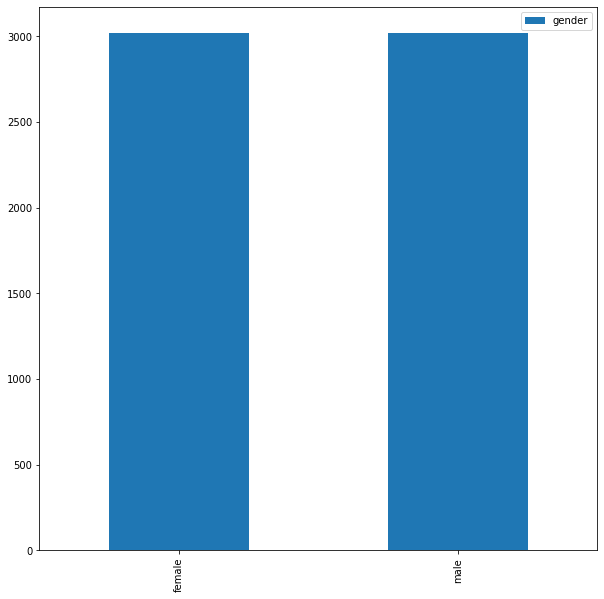

In [10]:
pd.DataFrame(sampled_df.gender.value_counts()).plot.bar(figsize=(10,10))

In [11]:
# if the training set has already been generated don't run this again - anyways this takes a pretty long time to extract
if not os.path.isfile("./recording_features.csv"):
    files = sampled_df.filename.to_list()
    features = []
    for i, filename in enumerate(files):
        recording_feature = import_mp3file(path, filename)
        features.append(recording_feature)
        if i % 100 == 0:
            print(f'Processed {i} records')

    final = pd.DataFrame(features)
    final.to_csv("recording_features.csv")
else:
    final = pd.read_csv("recording_features.csv", index_col=[0])

## Joining the two dataframes and standardizing the data


In [12]:
#time to remove columns we don't need
sampled_df = sampled_df.drop(columns=["up_votes", "down_votes", "duration", "accent", "index","text"])

In [13]:
# merge the two dataframes so we have the outcomes labels with the data
merged = pd.merge(sampled_df, final, on="filename")
merged

,filename,age,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19
0,cv-valid-train/sample-000005.mp3,twenties,female,1826.676487,1881.513079,3860.168457,-576.315370,86.375450,11.824992,49.361706,-5.830145,-0.714808,-14.106957,-8.645005,-2.919130,-14.076127,-14.482080,-13.578614,-6.720922,-6.186287,-4.839533,-9.007957,-3.113982,-1.743871,-9.447196,-8.065145
1,cv-valid-train/sample-000026.mp3,twenties,female,2616.617405,2179.803059,4761.842524,-228.240370,82.801940,-8.383657,30.143246,17.329943,2.232260,-19.801155,-6.005246,-7.787113,5.187589,-4.622561,-2.331251,-6.204039,3.251125,-17.747442,-0.515065,-10.605970,-8.131491,-8.427092,3.234301
2,cv-valid-train/sample-000059.mp3,twenties,female,2631.967942,2044.362034,4626.430442,-356.876740,68.245125,-10.347807,12.065706,-8.409592,-3.196407,-35.147610,-9.903251,-19.211166,-5.227669,-7.054412,-6.034971,-8.058039,-13.018083,-11.938355,3.690609,-8.656282,2.081685,-1.077340,-10.969205
3,cv-valid-train/sample-000101.mp3,twenties,female,2102.693066,1761.210243,3696.558838,-620.414300,95.137270,-1.270926,22.470818,-12.410017,-14.128232,-0.719716,-17.090850,-5.145642,0.527888,-14.900973,-17.381930,-8.984969,-7.450493,-7.771703,-7.896185,-9.588766,-11.281025,-8.105808,-1.190835
4,cv-valid-train/sample-000155.mp3,twenties,female,2238.837714,2250.816026,4440.932155,-383.868900,111.190480,9.153431,14.111599,11.028377,-8.014797,-10.864956,7.488869,8.158554,5.739348,-11.278584,-4.409180,-8.951644,-4.352331,-16.304008,-1.139749,-7.554811,-5.609372,-11.100672,0.755369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,cv-valid-train/sample-025095.mp3,fifties,female,2051.460400,1667.452561,3577.528733,-301.355438,79.975288,0.190885,34.674324,-20.913906,-0.836824,-27.546144,-12.159000,-17.359703,-6.070444,-7.549454,-14.079438,0.466185,-13.753979,-2.930482,-8.839911,6.860250,0.385507,-10.657043,-0.017750
6038,cv-valid-train/sample-025099.mp3,thirties,female,2069.099063,1779.094032,4045.764160,-444.592499,95.965050,-40.011948,34.227654,-19.243908,10.517472,-15.161172,-5.681414,-11.222052,-15.105099,-10.323715,-6.334144,-10.255620,-9.411448,1.272721,-14.257730,-1.601910,-6.940482,-2.772258,-5.349389
6039,cv-valid-train/sample-025101.mp3,fifties,female,1139.532627,1015.634039,2070.086200,-332.691833,162.807846,-15.643970,-6.910396,10.141964,-19.071936,-8.032710,-2.640061,-13.640615,-1.338096,-6.170706,-6.273840,-10.160578,-4.132409,-7.258778,-13.402951,-3.906369,-2.138798,-12.781569,-5.953580
6040,cv-valid-train/sample-025121.mp3,twenties,female,1977.609534,1537.759136,3541.956327,-393.188293,83.873909,-9.200700,22.312500,-6.095089,-14.024649,-13.559467,-3.634256,-10.940536,-6.731897,-3.180496,-5.419436,-3.416234,-6.169975,-0.814313,-5.441545,-2.891387,-4.688446,-7.295575,-3.764901


In [14]:
# switching female and male into 0 and 1
merged['gender_num'] = merged.gender.apply(lambda a : 1 if a=="male" else 0)

In [47]:
from sklearn.preprocessing import MinMaxScaler
X = merged.loc[:, 'spectral_centroid':'MFCC_19']
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
y = merged.gender_num

## Building models
### Logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_scale,y)
y_pred = log_model.predict(X_scale)


[[2524  497]
 [ 509 2512]]
accuracy is 0.8334988414432307


c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


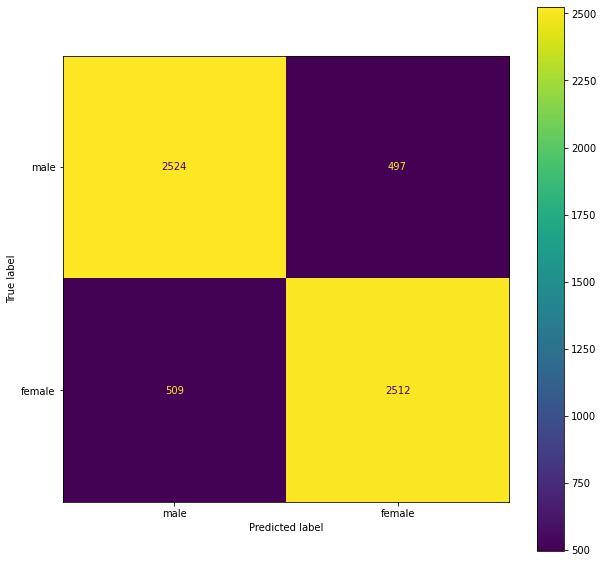

In [55]:
from sklearn import metrics
print(metrics.confusion_matrix(y, y_pred))
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(log_model, X_scale, y, display_labels=['male', 'female'], values_format='d', ax=ax)
print(f'accuracy is {metrics.accuracy_score(y, y_pred)}')   # accuracy

In [18]:
logistic_accuracy = metrics.accuracy_score(y, y_pred)
print(metrics.accuracy_score(y, y_pred))   # accuracy
print(metrics.precision_score(y, y_pred))  # precision
print(metrics.recall_score(y, y_pred))     # recall
print(metrics.f1_score(y, y_pred))

0.8334988414432307
0.8348288467929544
0.8315127441244621
0.833167495854063


c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


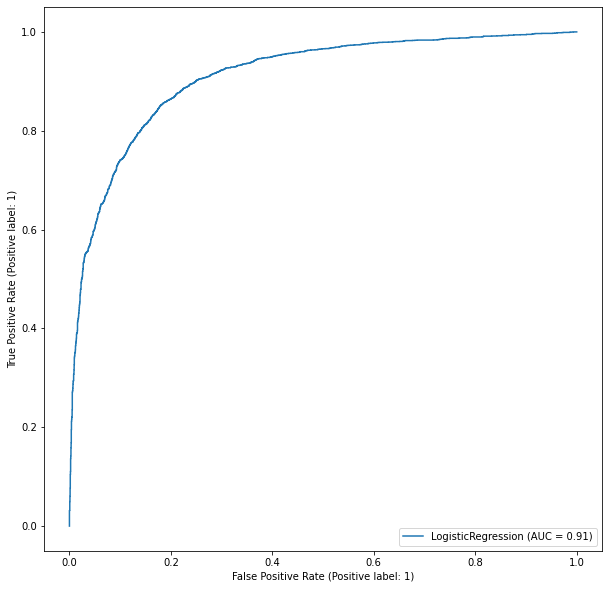

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_roc_curve(log_model, X_scale, y, ax=ax)

## K nearest neighbours

In [20]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.1)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5437, 23), (605, 23), (5437,), (605,))

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

errors = []
for k in range(1,80,2):
    model = KNeighborsClassifier(n_neighbors=k)
    errors.append({
        'k': k,
        'classification error': 1 - cross_val_score(model, X_train, y_train, cv=5).mean()
    })

results = pd.DataFrame(errors)
results.min()

k                       1.000000
classification error    0.099872
dtype: float64

In [22]:
#results
results.sort_values(by=['classification error']).head()

,k,classification error
0,1,0.099872
1,3,0.101159
2,5,0.104286
3,7,0.109619
4,9,0.110173


<AxesSubplot:xlabel='k', ylabel='classification error'>

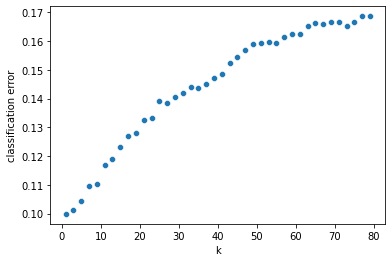

In [23]:
import seaborn as sns
sns.scatterplot(x='k', y='classification error', data=results)

In [24]:
kn_model = KNeighborsClassifier(n_neighbors=3)
kn_model.fit(X_train, y_train)
y_pred = kn_model.predict(X_test)
1 - kn_model.score(X_test,y_test)
kn_accuracy = metrics.accuracy_score(y_test, y_pred)
print(kn_accuracy)

0.912396694214876


# Decision trees
We start with scaling again although it wouldn't be necessary for the decision trees

In [58]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
X = merged.loc[:, 'spectral_centroid':'MFCC_19']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = merged.gender_num

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [59]:
# Trying to find which tree may be the best to build
from sklearn.model_selection import GridSearchCV
#
# # initial attempt
# param_grid = {
#     'max_depth': [10, 20, 30, 40],
#     'min_samples_split': [20, 40, 60, 80, 100],
#     'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01]
# }
#
# model = DecisionTreeClassifier(random_state=1)
#
# gridSearch = GridSearchCV(model, param_grid, cv=5)
# gridSearch.fit(X_train, y_train)
#
# print(gridSearch.best_score_)
# print(gridSearch.best_params_)

In [62]:
import dmba
from sklearn.ensemble import GradientBoostingClassifier

model_boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.12)
model_boost.fit(X_train, y_train)

dmba.classificationSummary(y_test, model_boost.predict(X_test))
metrics.plot_confusion_matrix(model_boost, X_test, y_test, display_labels=['male', 'female'], values_format='d', ax=ax)
print(f'accuracy is {metrics.accuracy_score(y, y_pred)}')   # accuracy

Confusion Matrix (Accuracy 0.8482)

       Prediction
Actual    0    1
     0 1001  166
     1  201 1049
accuracy is 0.8334988414432307


c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[Text(0.5, 0.875, 'X[4] <= 0.386\nfriedman_mse = 0.102\nsamples = 3625\nvalue = -0.0'),
 Text(0.25, 0.625, 'X[6] <= 0.563\nfriedman_mse = 0.105\nsamples = 852\nvalue = -0.046'),
 Text(0.125, 0.375, 'X[14] <= 0.44\nfriedman_mse = 0.102\nsamples = 815\nvalue = -0.054'),
 Text(0.0625, 0.125, 'friedman_mse = 0.059\nsamples = 173\nvalue = -0.866'),
 Text(0.1875, 0.125, 'friedman_mse = 0.111\nsamples = 642\nvalue = -0.198'),
 Text(0.375, 0.375, 'X[15] <= 0.538\nfriedman_mse = 0.151\nsamples = 37\nvalue = 0.14'),
 Text(0.3125, 0.125, 'friedman_mse = 0.119\nsamples = 16\nvalue = 1.875'),
 Text(0.4375, 0.125, 'friedman_mse = 0.106\nsamples = 21\nvalue = -0.206'),
 Text(0.75, 0.625, 'X[6] <= 0.439\nfriedman_mse = 0.1\nsamples = 2773\nvalue = 0.014'),
 Text(0.625, 0.375, 'X[7] <= 0.763\nfriedman_mse = 0.102\nsamples = 1924\nvalue = -0.005'),
 Text(0.5625, 0.125, 'friedman_mse = 0.103\nsamples = 1859\nvalue = -0.074'),
 Text(0.6875, 0.125, 'friedman_mse = 0.035\nsamples = 65\nvalue = 1.141'),
 Tex

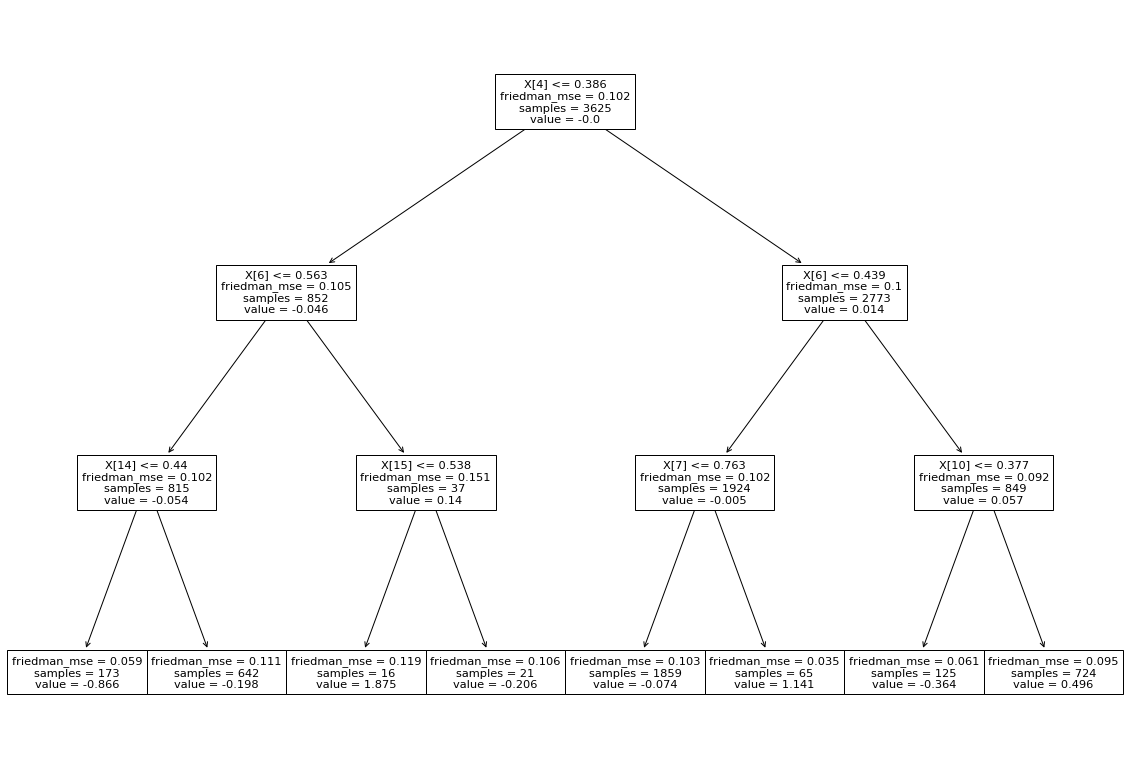

In [66]:
atree = model_boost.estimators_[42,0]
plt.figure(figsize=(20,14)) 
plot_tree(atree)

In [28]:
# Testing the outcome

dmba.classificationSummary(y_train, model_boost.predict(X_train))
dmba.classificationSummary(y_test, model_boost.predict(X_test))
boosted_tree_accuracy = metrics.accuracy_score(y_test, model_boost.predict(X_test))

Confusion Matrix (Accuracy 0.9484)

       Prediction
Actual    0    1
     0 1731   97
     1   90 1707
Confusion Matrix (Accuracy 0.8506)

       Prediction
Actual    0    1
     0 1018  175
     1  186 1038


## Just for curiosity a neural network as the tip of the iceberg

In [29]:
from sklearn.neural_network import MLPClassifier

X = merged.loc[:, 'spectral_centroid':'MFCC_19']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = merged.gender_num

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [75]:
clf = MLPClassifier(solver='adam', alpha=1e-5,
                 hidden_layer_sizes=(5, 2, 2))
clf.fit(X_train, y_train)

c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2, 2))

In [76]:
from sklearn.metrics import accuracy_score
predicted_values = clf.predict(X_test)
neural_accuracy = accuracy_score(y_test,predicted_values)
print(neural_accuracy)

0.8225072403806372


In [32]:
from sklearn.model_selection import GridSearchCV
my_bool = False
if my_bool:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    clf = MLPClassifier(solver='adam',hidden_layer_sizes=(7,7,7))

    params = {
        'hidden_layer_sizes' : [(5,2,3), (5,2,4)] # Every combination you want to try
    }

    gscv = GridSearchCV(clf, params, verbose=1)

    gscv.fit(np.array(X_train), np.array(y_train))
    print(gscv.best_params_)

    predicted_values = gscv.predict(X_test)

    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,predicted_values)

    print(score)

In [33]:
import pickle
pickle.dump(log_model, open("LogisticRegression.model", "wb"))
pickle.dump(kn_model, open("KNeighborsClassifier.model", "wb"))
pickle.dump(model_boost, open("GradientBoostingClassifier.model", "wb" ))
pickle.dump(scaler, open("MinMaxScaler.scaler", "wb"))

## Testing on locally recorded files - this should be built into a React dashboard

In [34]:
# Testing on new files
test_file = import_mp3file("./", "Recording_2.m4a")
test_frame = pd.DataFrame(test_file, index=[0])
X = test_frame.loc[:, 'spectral_centroid':'MFCC_19']
TEST = scaler.transform(X)

predicted_logistic = log_model.predict(TEST)
print(f'Predicted for logistic regression: {predicted_logistic}')

k_predicted = kn_model.predict(TEST)
print( (f'Predicted for K-nearest neigbours: {k_predicted}'))

boosted_tree = model_boost.predict(TEST)
print(f'Predicted for boosted tree: {boosted_tree}')

neural_network = clf.predict(TEST)
print(f'Neural network predicts {neural_network}')


c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Predicted for logistic regression: [1]
Predicted for K-nearest neigbours: [1]
Predicted for boosted tree: [1]
Neural network predicts [1]


# Ensemble final model

In [36]:
# from sklearn.ensemble import VotingClassifier

# models = [("log_model", log_model), ("k_nearest", kn_model), ("GradientBoostingClassifier", boosted_tree),
#           ("neural_network", neural_network)]
# weights = [logistic_accuracy, kn_accuracy, boosted_tree_accuracy, neural_accuracy]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# #ensemble = VotingClassifier(estimators=models, weights=weights, voting='soft')
# #ensemble.fit(X_train, y_train)



In [74]:
test_file = import_mp3file("C:\\Users\\ASemjen\\OneDrive - Confluent\\Documents\\Sound recordings", "Recording (21).m4a")
#test_file = import_mp3file("./", "Recording_Anna_again.m4a")

test_frame = pd.DataFrame(test_file, index=[0])
X = test_frame.loc[:, 'spectral_centroid':'MFCC_19']
TEST = scaler.transform(X)


predicted_logistic = log_model.predict(TEST)
print(f'Predicted for logistic regression: {predicted_logistic}')
print(f'logistic accuracy is {logistic_accuracy}')

k_predicted = kn_model.predict(TEST)
print( (f'Predicted for K-nearest neigbours: {k_predicted}'))
print(f'K nearest accuracy is {kn_accuracy}')

boosted_tree = model_boost.predict(TEST)
print(f'Predicted for boosted tree: {boosted_tree}')
print(f'Gradient boosted tree accuracy is {boosted_tree_accuracy}')


neural_network = clf.predict(TEST)
print(f'Neural network predicts {neural_network}')
print(f'Neural accuracy {neural_accuracy}')


c:\users\asemjen\appdata\local\programs\python\python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Predicted for logistic regression: [1]
logistic accuracy is 0.8334988414432307
Predicted for K-nearest neigbours: [1]
K nearest accuracy is 0.912396694214876
Predicted for boosted tree: [1]
Gradient boosted tree accuracy is 0.8506412908564336
Neural network predicts [1]
Neural accuracy 0.8304383788254756
